In [33]:
# -*- coding: utf-8 -*-
"""Комплексный анализ классификации и кластеризации - исправленная версия"""

# ==================== УСТАНОВКА НЕОБХОДИМЫХ БИБЛИОТЕК ====================
import subprocess
import sys
import importlib

def install_package(package):
    """Установка пакета, если он не установлен"""
    try:
        importlib.import_module(package)
        print(f"✓ {package} уже установлен")
    except ImportError:
        print(f"⚠ Установка {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} успешно установлен")

# Список необходимых библиотек
required_packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'nbformat',
    'scipy'
]

print("="*60)
print("ПРОВЕРКА И УСТАНОВКА НЕОБХОДИМЫХ БИБЛИОТЕК")
print("="*60)

for package in required_packages:
    if package == 'scikit-learn':
        install_package('sklearn')
    elif package == 'nbformat':
        try:
            import nbformat
            if int(nbformat.__version__.split('.')[0]) < 4:
                print("⚠ Обновление nbformat...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "nbformat>=4.2.0"])
        except:
            install_package('nbformat>=4.2.0')
    else:
        install_package(package)

print("\n" + "="*60)
print("ВСЕ БИБЛИОТЕКИ УСТАНОВЛЕНЫ!")
print("="*60 + "\n")

# ==================== ИМПОРТ БИБЛИОТЕК ====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           silhouette_score, davies_bouldin_score, calinski_harabasz_score,
                           roc_curve, auc, roc_auc_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Установка стилей для графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== КЛАССИФИКАЦИЯ ====================

# Импорт моделей классификации
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# ==================== КЛАСТЕРИЗАЦИЯ ====================

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

class AdvancedMLAnalyzer:
    """
    Продвинутый анализатор для задач машинного обучения
    с комплексной визуализацией и анализом
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        self.clustering_results = {}
        
    def load_and_prepare_data(self, filepath=None, data=None, target_col=None):
        """
        Загрузка и подготовка данных
        """
        if filepath:
            print(f"📁 Загрузка данных из {filepath}...")
            if filepath.endswith('.csv'):
                self.df = pd.read_csv(filepath)
            elif filepath.endswith('.xlsx'):
                self.df = pd.read_excel(filepath)
            elif filepath.endswith('.json'):
                self.df = pd.read_json(filepath)
            else:
                raise ValueError("Неподдерживаемый формат файла")
        elif data is not None:
            print("📊 Использование предоставленных данных...")
            self.df = data.copy()
        else:
            raise ValueError("Необходимо предоставить данные или путь к файлу")
            
        print(f"📊 Размер данных: {self.df.shape}")
        print(f"📋 Колонки: {self.df.columns.tolist()}")
        
        # Базовая информация о данных
        info_df = pd.DataFrame({
            'Тип данных': self.df.dtypes,
            'Уникальных значений': self.df.nunique(),
            'Пропущенных значений': self.df.isnull().sum(),
            'Заполненность (%)': (1 - self.df.isnull().sum() / len(self.df)) * 100
        })
        print("\n🔍 Информация о данных:")
        print(info_df)
        
        # Описательная статистика
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"\n📈 Описательная статистика:")
            print(self.df[numeric_cols].describe().round(2))
        
        # Проверка на пропущенные значения
        missing_values = self.df.isnull().sum()
        missing_total = missing_values.sum()
        
        if missing_total > 0:
            print(f"\n⚠ Обнаружено {missing_total} пропущенных значений")
            # Автоматическая обработка
            self._handle_missing_values()
        
        self.target_col = target_col
        return self.df
    
    def _handle_missing_values(self, strategy='median'):
        """Автоматическая обработка пропущенных значений"""
        original_shape = self.df.shape
        
        if strategy == 'drop':
            self.df = self.df.dropna()
        elif strategy == 'mean':
            self.df = self.df.fillna(self.df.mean())
        elif strategy == 'median':
            self.df = self.df.fillna(self.df.median())
        elif strategy == 'mode':
            for col in self.df.columns:
                if self.df[col].dtype == 'object':
                    self.df[col] = self.df[col].fillna(self.df[col].mode()[0] if not self.df[col].mode().empty else 'Unknown')
                else:
                    self.df[col] = self.df[col].fillna(self.df[col].median())
        
        print(f"📊 Данные обработаны. Было: {original_shape}, стало: {self.df.shape}")
    
    def exploratory_visualization(self):
        """
        Упрощенная визуализация для разведочного анализа данных
        """
        print("\n" + "="*60)
        print("📊 РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ")
        print("="*60)
        
        # Создаем несколько отдельных графиков
        
        # 1. Распределение целевой переменной
        if self.target_col and self.target_col in self.df.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            target_counts = self.df[self.target_col].value_counts()
            colors = plt.cm.Set3(np.linspace(0, 1, len(target_counts)))
            
            # Круговая диаграмма
            ax1.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
                   colors=colors, startangle=90)
            ax1.set_title(f'Распределение {self.target_col}')
            
            # Столбчатая диаграмма
            bars = ax2.bar(range(len(target_counts)), target_counts.values, color=colors)
            ax2.set_title(f'Количество по {self.target_col}')
            ax2.set_xticks(range(len(target_counts)))
            ax2.set_xticklabels(target_counts.index, rotation=45)
            ax2.set_ylabel('Количество')
            
            # Добавляем значения на столбцы
            for i, count in enumerate(target_counts.values):
                ax2.text(i, count + max(target_counts.values)*0.01, str(count), 
                       ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()
        
        # 2. Корреляционная матрица
        numeric_df = self.df.select_dtypes(include=[np.number])
        if not numeric_df.empty and len(numeric_df.columns) > 1:
            fig, ax = plt.subplots(figsize=(10, 8))
            corr_matrix = numeric_df.corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                       cmap='coolwarm', center=0, ax=ax, square=True,
                       cbar_kws={"shrink": 0.8})
            ax.set_title('Корреляционная матрица')
            plt.tight_layout()
            plt.show()
        
        # 3. Распределение числовых признаков (первые 6)
        if not numeric_df.empty:
            n_features = min(6, len(numeric_df.columns))
            n_cols = 2
            n_rows = (n_features + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
            axes = axes.flatten() if n_rows > 1 else [axes]
            
            for i, col in enumerate(numeric_df.columns[:n_features]):
                axes[i].hist(numeric_df[col], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
                axes[i].set_title(f'Распределение {col}')
                axes[i].set_xlabel('Значение')
                axes[i].set_ylabel('Частота')
            
            # Скрываем пустые подграфики
            for i in range(n_features, len(axes)):
                axes[i].set_visible(False)
            
            plt.tight_layout()
            plt.show()
        
        # 4. Boxplot для выбросов (первые 6 признаков)
        if not numeric_df.empty:
            n_features = min(6, len(numeric_df.columns))
            fig, ax = plt.subplots(figsize=(12, 6))
            numeric_limited = numeric_df.iloc[:, :n_features]
            sns.boxplot(data=numeric_limited, ax=ax, palette='Set2')
            ax.set_title('Boxplot (выбросы)')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            plt.tight_layout()
            plt.show()
        
        return numeric_df
    
    def prepare_classification_data(self, test_size=0.2, features_to_drop=None):
        """
        Подготовка данных для классификации
        """
        if not self.target_col:
            raise ValueError("Необходимо указать целевую переменную через параметр target_col")
            
        print(f"\n🎯 Подготовка данных для классификации...")
        print(f"   Целевая переменная: {self.target_col}")
        
        # Выбор признаков
        if features_to_drop:
            X = self.df.drop(columns=[self.target_col] + features_to_drop)
            print(f"   Удалено признаков: {len(features_to_drop)}")
        else:
            X = self.df.drop(columns=[self.target_col])
        
        y = self.df[self.target_col]
        
        print(f"   Признаков для обучения: {X.shape[1]}")
        print(f"   Размер выборки: {len(X)}")
        
        # Кодирование категориальных признаков
        categorical_cols = X.select_dtypes(include=['object']).columns
        if len(categorical_cols) > 0:
            print(f"   Кодирование {len(categorical_cols)} категориальных признаков...")
            X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
        
        # Кодирование целевой переменной, если необходимо
        if y.dtype == 'object':
            print("   Кодирование целевой переменной...")
            self.label_encoder = LabelEncoder()
            y_encoded = self.label_encoder.fit_transform(y)
            class_mapping = dict(zip(self.label_encoder.classes_, 
                                   self.label_encoder.transform(self.label_encoder.classes_)))
            print(f"   Маппинг классов: {class_mapping}")
            y = y_encoded
        else:
            self.label_encoder = None
        
        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, 
            random_state=self.random_state, 
            stratify=y if len(np.unique(y)) > 1 else None
        )
        
        print(f"   Тренировочная выборка: {X_train.shape}")
        print(f"   Тестовая выборка: {X_test.shape}")
        
        # Масштабирование
        print("   Масштабирование признаков...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.X_train, self.X_test = X_train_scaled, X_test_scaled
        self.y_train, self.y_test = y_train, y_test
        self.feature_names = X.columns.tolist()
        
        # Анализ баланса классов
        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        print(f"\n⚖️  Баланс классов в тренировочной выборке:")
        for cls, count in zip(unique_classes, class_counts):
            percentage = count / len(y_train) * 100
            print(f"   Класс {cls}: {count} образцов ({percentage:.1f}%)")
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_classification_models(self, models_to_use=None):
        """
        Обучение моделей классификации с оптимизацией
        """
        if models_to_use is None:
            models_to_use = ['Logistic Regression', 'Decision Tree', 
                            'Random Forest', 'SVM', 'KNN']
        
        print("\n" + "="*60)
        print("🤖 ОБУЧЕНИЕ МОДЕЛЕЙ КЛАССИФИКАЦИИ")
        print("="*60)
        
        # Определение моделей
        models_config = {
            'Logistic Regression': {
                'model': LogisticRegression(random_state=self.random_state, 
                                          max_iter=1000, class_weight='balanced')
            },
            'Decision Tree': {
                'model': DecisionTreeClassifier(random_state=self.random_state,
                                              class_weight='balanced')
            },
            'Random Forest': {
                'model': RandomForestClassifier(random_state=self.random_state,
                                              n_estimators=100,
                                              class_weight='balanced')
            },
            'SVM': {
                'model': SVC(random_state=self.random_state,
                           probability=True,
                           class_weight='balanced')
            },
            'KNN': {
                'model': KNeighborsClassifier()
            }
        }
        
        results_summary = []
        
        for name in models_to_use:
            if name not in models_config:
                print(f"⚠ Модель {name} не поддерживается. Пропускаем.")
                continue
            
            print(f"\n{'='*40}")
            print(f"📊 Модель: {name}")
            print(f"{'='*40}")
            
            config = models_config[name]
            model = config['model']
            
            # Обучение с кросс-валидацией
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                       cv=5, scoring='accuracy', n_jobs=-1)
            
            # Обучение на полной тренировочной выборке
            model.fit(self.X_train, self.y_train)
            
            # Предсказания
            y_pred_train = model.predict(self.X_train)
            y_pred_test = model.predict(self.X_test)
            
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(self.X_test)
            else:
                y_proba_test = None
            
            # Метрики
            train_accuracy = accuracy_score(self.y_train, y_pred_train)
            test_accuracy = accuracy_score(self.y_test, y_pred_test)
            precision = precision_score(self.y_test, y_pred_test, average='weighted')
            recall = recall_score(self.y_test, y_pred_test, average='weighted')
            f1 = f1_score(self.y_test, y_pred_test, average='weighted')
            
            # Сохранение результатов
            self.models[name] = model
            self.results[name] = {
                'model': model,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'predictions': y_pred_test,
                'probabilities': y_proba_test,
                'cv_scores': cv_scores
            }
            
            # Вывод результатов
            print(f"✅ Точность на тренировочных данных: {train_accuracy:.4f}")
            print(f"✅ Точность на тестовых данных: {test_accuracy:.4f}")
            print(f"✅ Precision: {precision:.4f}")
            print(f"✅ Recall: {recall:.4f}")
            print(f"✅ F1-Score: {f1:.4f}")
            print(f"📊 Кросс-валидация (5-fold):")
            print(f"   Среднее: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            
            results_summary.append({
                'Модель': name,
                'Train Acc': train_accuracy,
                'Test Acc': test_accuracy,
                'CV Mean': cv_scores.mean(),
                'CV Std': cv_scores.std(),
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            })
        
        # Сводная таблица результатов
        print("\n" + "="*60)
        print("📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
        print("="*60)
        
        summary_df = pd.DataFrame(results_summary)
        summary_df = summary_df.sort_values('Test Acc', ascending=False)
        
        pd.set_option('display.float_format', lambda x: f'{x:.4f}')
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        
        print(summary_df.to_string(index=False))
        
        return self.results
    
    def visualize_classification_performance(self):
        """
        Комплексная визуализация производительности моделей
        """
        if not self.results:
            print("⚠ Нет результатов для визуализации. Сначала обучите модели.")
            return
        
        print("\n" + "="*60)
        print("📈 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ")
        print("="*60)
        
        model_names = list(self.results.keys())
        
        # 1. Сравнение точности моделей
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        test_accuracies = [self.results[m]['test_accuracy'] for m in model_names]
        train_accuracies = [self.results[m]['train_accuracy'] for m in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax1.bar(x - width/2, train_accuracies, width, label='Train', alpha=0.7, color='skyblue')
        ax1.bar(x + width/2, test_accuracies, width, label='Test', alpha=0.7, color='lightcoral')
        
        ax1.set_xlabel('Модели')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Сравнение точности моделей')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Добавление значений на столбцы
        for i, (train, test) in enumerate(zip(train_accuracies, test_accuracies)):
            ax1.text(i - width/2, train + 0.01, f'{train:.3f}', 
                    ha='center', va='bottom', fontsize=9)
            ax1.text(i + width/2, test + 0.01, f'{test:.3f}', 
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # 2. Confusion Matrix для лучшей модели
        best_model_name = max(self.results, key=lambda x: self.results[x]['test_accuracy'])
        best_result = self.results[best_model_name]
        
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        cm = confusion_matrix(self.y_test, best_result['predictions'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                   xticklabels=np.unique(self.y_test),
                   yticklabels=np.unique(self.y_test))
        ax2.set_xlabel('Предсказанные метки')
        ax2.set_ylabel('Истинные метки')
        ax2.set_title(f'Confusion Matrix: {best_model_name}')
        plt.tight_layout()
        plt.show()
        
        # 3. ROC кривые (для бинарной классификации)
        if len(np.unique(self.y_test)) == 2:
            fig3, ax3 = plt.subplots(figsize=(10, 6))
            
            for name, result in self.results.items():
                if result['probabilities'] is not None:
                    fpr, tpr, _ = roc_curve(self.y_test, result['probabilities'][:, 1])
                    roc_auc = auc(fpr, tpr)
                    
                    ax3.plot(fpr, tpr, lw=2, 
                            label=f'{name} (AUC = {roc_auc:.3f})')
            
            ax3.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор')
            ax3.set_xlim([0.0, 1.0])
            ax3.set_ylim([0.0, 1.05])
            ax3.set_xlabel('False Positive Rate')
            ax3.set_ylabel('True Positive Rate')
            ax3.set_title('ROC кривые')
            ax3.legend(loc="lower right")
            ax3.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # 4. Важность признаков (для Random Forest)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']
            
            if hasattr(rf_model, 'feature_importances_'):
                importances = rf_model.feature_importances_
                indices = np.argsort(importances)[-10:]  # Топ-10 признаков
                
                fig4, ax4 = plt.subplots(figsize=(10, 6))
                
                # Ограничиваем названия признаков для читаемости
                feature_labels = []
                for idx in indices:
                    name = self.feature_names[idx]
                    if len(name) > 30:
                        name = name[:27] + '...'
                    feature_labels.append(name)
                
                ax4.barh(range(len(indices)), importances[indices], 
                        color='lightgreen', alpha=0.7)
                ax4.set_yticks(range(len(indices)))
                ax4.set_yticklabels(feature_labels)
                ax4.set_xlabel('Важность')
                ax4.set_title('Топ-10 признаков по важности (Random Forest)')
                ax4.grid(True, alpha=0.3, axis='x')
                plt.tight_layout()
                plt.show()
        
        # 5. Кривые обучения для лучшей модели
        if best_model_name in self.models:
            try:
                train_sizes, train_scores, test_scores = learning_curve(
                    self.models[best_model_name], self.X_train, self.y_train,
                    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
                    scoring='accuracy', random_state=self.random_state
                )
                
                fig5, ax5 = plt.subplots(figsize=(10, 6))
                
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)
                
                ax5.fill_between(train_sizes, train_mean - train_std,
                               train_mean + train_std, alpha=0.1, color='blue')
                ax5.fill_between(train_sizes, test_mean - test_std,
                               test_mean + test_std, alpha=0.1, color='orange')
                
                ax5.plot(train_sizes, train_mean, 'o-', color='blue', 
                        label='Тренировочная точность')
                ax5.plot(train_sizes, test_mean, 'o-', color='orange', 
                        label='Кросс-валидационная точность')
                
                ax5.set_xlabel('Размер тренировочной выборки')
                ax5.set_ylabel('Accuracy')
                ax5.set_title(f'Кривые обучения: {best_model_name}')
                ax5.legend(loc='best')
                ax5.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"⚠ Не удалось построить кривые обучения: {e}")
        
        # 6. Сравнение метрик для всех моделей
        fig6, ax6 = plt.subplots(figsize=(12, 6))
        
        metrics_to_plot = ['precision', 'recall', 'f1']
        colors = ['blue', 'green', 'red']
        
        x = np.arange(len(model_names))
        width = 0.25
        
        for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
            values = [self.results[m][metric] for m in model_names]
            offset = (i - 1) * width
            ax6.bar(x + offset, values, width, 
                   label=metric.capitalize(), alpha=0.7, color=color)
        
        ax6.set_xlabel('Модели')
        ax6.set_ylabel('Значение')
        ax6.set_title('Сравнение метрик классификации')
        ax6.set_xticks(x)
        ax6.set_xticklabels(model_names, rotation=45, ha='right')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Детальный отчет по лучшей модели
        print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print(f"📊 Точность: {best_result['test_accuracy']:.4f}")
        print(f"📈 F1-Score: {best_result['f1']:.4f}")
        
        print("\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ:")
        print(classification_report(self.y_test, best_result['predictions']))
        
        return best_model_name
    
    def perform_clustering_analysis(self, n_clusters_range=None, features=None):
        """
        Комплексный анализ кластеризации с оптимизацией количества кластеров
        """
        if n_clusters_range is None:
            n_clusters_range = range(2, 8)
            
        if features is None:
            features = self.df.select_dtypes(include=[np.number])
            if len(features.columns) == 0:
                print("⚠ Нет числовых признаков для кластеризации")
                return None
            print(f"📊 Использовано {features.shape[1]} числовых признаков")
        
        # Масштабирование данных
        features_scaled = self.scaler.fit_transform(features)
        
        print("\n" + "="*60)
        print("🔍 АНАЛИЗ КЛАСТЕРИЗАЦИИ")
        print("="*60)
        
        # 1. Определение оптимального количества кластеров
        print("\n📐 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ")
        print("-" * 40)
        
        wcss = []  # Within-Cluster Sum of Squares
        silhouette_scores = []
        
        # Ограничиваем диапазон для производительности
        max_clusters = min(10, len(features) // 10, 10)  # Максимум 10 кластеров или 1 кластер на 10 образцов
        n_clusters_range = range(2, min(max_clusters, 11))
        
        for n_clusters in n_clusters_range:
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10)
                clusters = kmeans.fit_predict(features_scaled)
                
                wcss.append(kmeans.inertia_)
                
                if n_clusters > 1:
                    silhouette_avg = silhouette_score(features_scaled, clusters)
                    silhouette_scores.append(silhouette_avg)
                    print(f"Кластеров: {n_clusters:2d} | WCSS: {kmeans.inertia_:10.2f} | "
                          f"Silhouette: {silhouette_avg:.4f}")
            except Exception as e:
                print(f"⚠ Ошибка при n_clusters={n_clusters}: {e}")
                wcss.append(np.nan)
                if n_clusters > 1:
                    silhouette_scores.append(np.nan)
        
        # Визуализация методов локтя и силуэта
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Метод локтя
        valid_wcss = [w for w in wcss if not np.isnan(w)]
        valid_n_clusters = [n for n, w in zip(n_clusters_range, wcss) if not np.isnan(w)]
        
        if len(valid_wcss) > 0:
            ax1.plot(valid_n_clusters, valid_wcss, 'bo-', linewidth=2, markersize=8)
            ax1.set_xlabel('Количество кластеров')
            ax1.set_ylabel('WCSS')
            ax1.set_title('Метод локтя')
            ax1.grid(True, alpha=0.3)
        else:
            ax1.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title('Метод локтя (нет данных)')
        
        # Метод силуэта
        valid_silhouette = [s for s in silhouette_scores if not np.isnan(s)]
        valid_n_clusters_silhouette = list(n_clusters_range)[:len(valid_silhouette)]
        
        if len(valid_silhouette) > 0:
            ax2.plot(valid_n_clusters_silhouette, valid_silhouette, 'ro-', 
                    linewidth=2, markersize=8)
            ax2.set_xlabel('Количество кластеров')
            ax2.set_ylabel('Silhouette Score')
            ax2.set_title('Метод силуэта')
            ax2.grid(True, alpha=0.3)
            
            # Определение оптимального количества кластеров
            optimal_n = valid_n_clusters_silhouette[np.argmax(valid_silhouette)]
            print(f"\n✅ Оптимальное количество кластеров: {optimal_n} "
                  f"(Silhouette: {max(valid_silhouette):.4f})")
        else:
            ax2.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Метод силуэта (нет данных)')
            optimal_n = 3
            print(f"\n✅ Используем {optimal_n} кластера(ов) по умолчанию")
        
        plt.tight_layout()
        plt.show()
        
        # 2. Применение различных алгоритмов кластеризации
        print(f"\n🤖 ПРИМЕНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ (n_clusters={optimal_n})")
        print("-" * 40)
        
        clustering_algorithms = {
            'K-Means': KMeans(n_clusters=optimal_n, random_state=self.random_state, n_init=10),
            'Agglomerative': AgglomerativeClustering(n_clusters=optimal_n),
            'Gaussian Mixture': GaussianMixture(n_components=optimal_n, 
                                               random_state=self.random_state)
        }
        
        # Добавляем DBSCAN только если данных достаточно
        if len(features) > 10:
            clustering_algorithms['DBSCAN'] = DBSCAN(eps=0.5, min_samples=5)
        
        self.clustering_results = {}
        
        for name, algorithm in clustering_algorithms.items():
            print(f"\n📊 Алгоритм: {name}")
            
            try:
                if name == 'Gaussian Mixture':
                    algorithm.fit(features_scaled)
                    clusters = algorithm.predict(features_scaled)
                    probabilities = algorithm.predict_proba(features_scaled)
                else:
                    clusters = algorithm.fit_predict(features_scaled)
                    probabilities = None
                
                # Расчет метрик
                unique_clusters = np.unique(clusters)
                n_unique = len(unique_clusters)
                
                if n_unique > 1:
                    silhouette = silhouette_score(features_scaled, clusters)
                    davies_bouldin = davies_bouldin_score(features_scaled, clusters)
                    calinski_harabasz = calinski_harabasz_score(features_scaled, clusters)
                    
                    print(f"   Количество кластеров: {n_unique}")
                    print(f"   Silhouette Score: {silhouette:.4f}")
                    print(f"   Davies-Bouldin Index: {davies_bouldin:.4f}")
                    print(f"   Calinski-Harabasz Index: {calinski_harabasz:.4f}")
                    
                    self.clustering_results[name] = {
                        'algorithm': algorithm,
                        'clusters': clusters,
                        'probabilities': probabilities,
                        'silhouette': silhouette,
                        'davies_bouldin': davies_bouldin,
                        'calinski_harabasz': calinski_harabasz,
                        'n_clusters': n_unique
                    }
                else:
                    print(f"   ⚠ Обнаружен только 1 кластер")
                    self.clustering_results[name] = None
                    
            except Exception as e:
                print(f"   ❌ Ошибка: {str(e)}")
                self.clustering_results[name] = None
        
        self.features_scaled = features_scaled
        self.features_original = features
        
        return self.clustering_results
    
    def visualize_clustering_results(self):
        """
        Упрощенная визуализация результатов кластеризации
        """
        if not self.clustering_results:
            print("⚠ Нет результатов кластеризации для визуализации")
            return
        
        valid_results = {k: v for k, v in self.clustering_results.items() 
                        if v is not None and v.get('silhouette') is not None}
        
        if not valid_results:
            print("⚠ Нет валидных результатов кластеризации")
            return
        
        print("\n" + "="*60)
        print("🎨 ВИЗУАЛИЗАЦИЯ КЛАСТЕРИЗАЦИИ")
        print("="*60)
        
        # Выбор лучшего алгоритма
        best_algorithm_name = max(valid_results, key=lambda x: valid_results[x]['silhouette'])
        best_result = valid_results[best_algorithm_name]
        clusters = best_result['clusters']
        
        print(f"🏆 Лучший алгоритм: {best_algorithm_name}")
        print(f"📊 Silhouette Score: {best_result['silhouette']:.4f}")
        print(f"🔢 Количество кластеров: {best_result['n_clusters']}")
        
        # 1. Сравнение алгоритмов
        fig1, ax1 = plt.subplots(figsize=(10, 6))
        algorithms = list(valid_results.keys())
        silhouette_scores = [valid_results[alg]['silhouette'] for alg in algorithms]
        
        bars = ax1.bar(algorithms, silhouette_scores, color=plt.cm.Set3(np.arange(len(algorithms))))
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Сравнение алгоритмов кластеризации')
        ax1.set_xticklabels(algorithms, rotation=45, ha='right')
        
        # Добавляем значения на столбцы
        for bar, score in zip(bars, silhouette_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        ax1.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # 2. PCA проекция кластеров
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        
        try:
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(self.features_scaled)
            
            scatter = ax2.scatter(pca_result[:, 0], pca_result[:, 1], 
                                c=clusters, cmap='viridis', 
                                s=50, alpha=0.6, edgecolors='w', linewidth=0.5)
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
            ax2.set_title('PCA проекция кластеров')
            plt.colorbar(scatter, ax=ax2, label='Кластер')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Ошибка PCA:\n{str(e)}', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('PCA проекция (ошибка)')
        
        plt.tight_layout()
        plt.show()
        
        # 3. Размеры кластеров
        fig3, (ax3_1, ax3_2) = plt.subplots(1, 2, figsize=(14, 6))
        
        unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
        
        # Круговая диаграмма
        if len(unique_clusters) > 0:
            wedges, texts, autotexts = ax3_1.pie(cluster_counts, 
                                              labels=[f'Cluster {c}' for c in unique_clusters],
                                              autopct='%1.1f%%',
                                              colors=plt.cm.Set3(np.arange(len(unique_clusters))),
                                              startangle=90)
            ax3_1.set_title('Распределение по кластерам')
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
        
        # Столбчатая диаграмма
        if len(unique_clusters) > 0:
            bars = ax3_2.bar(range(len(unique_clusters)), cluster_counts, 
                            color=plt.cm.Set3(np.arange(len(unique_clusters))))
            ax3_2.set_xlabel('Кластер')
            ax3_2.set_ylabel('Количество образцов')
            ax3_2.set_title('Размеры кластеров')
            ax3_2.set_xticks(range(len(unique_clusters)))
            ax3_2.set_xticklabels([f'Cluster {c}' for c in unique_clusters])
            
            # Добавляем значения на столбцы
            for bar, count in zip(bars, cluster_counts):
                height = bar.get_height()
                ax3_2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                          str(count), ha='center', va='bottom')
            
            ax3_2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # 4. Характеристики кластеров
        features_with_clusters = self.features_original.copy()
        features_with_clusters['Cluster'] = clusters
        
        cluster_means = features_with_clusters.groupby('Cluster').mean()
        
        if len(cluster_means.columns) > 0 and len(cluster_means) > 0:
            # Выбираем топ-5 признаков с наибольшей вариативностью между кластерами
            cluster_var = cluster_means.var()
            
            if len(cluster_var) > 0:
                n_features = min(5, len(cluster_var))
                top_features = cluster_var.nlargest(n_features).index.tolist()
                
                fig4, ax4 = plt.subplots(figsize=(12, 8))
                
                # Нормализуем для heatmap
                normalized_means = (cluster_means[top_features] - 
                                  cluster_means[top_features].min()) / \
                                 (cluster_means[top_features].max() - 
                                  cluster_means[top_features].min())
                
                sns.heatmap(normalized_means.T, annot=True, fmt='.2f', 
                           cmap='YlOrRd', ax=ax4, square=True,
                           cbar_kws={"shrink": 0.8})
                ax4.set_title(f'Нормализованные средние по кластерам\n(топ-{n_features} признаков)')
                ax4.set_xlabel('Кластер')
                plt.tight_layout()
                plt.show()
        
        # Детальный анализ кластеров
        print("\n📊 ДЕТАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:")
        print("-" * 40)
        
        for cluster in np.sort(np.unique(clusters)):
            cluster_data = features_with_clusters[features_with_clusters['Cluster'] == cluster]
            cluster_size = len(cluster_data)
            
            if cluster_size > 0:
                percentage = cluster_size / len(features_with_clusters) * 100
                print(f"\n🔹 Cluster {cluster}: {cluster_size} образцов ({percentage:.1f}%)")
                
                if len(cluster_data.columns) > 1:
                    mean_values = cluster_data.mean(numeric_only=True).sort_values(ascending=False)
                    top_features = mean_values.head(3)
                    
                    print(f"   Топ-3 признака (наибольшие значения):")
                    for feature, value in top_features.items():
                        print(f"     {feature}: {value:.3f}")
        
        return best_algorithm_name, clusters

# ==================== ПРИМЕР ИСПОЛЬЗОВАНИЯ ====================

def run_example_analysis():
    """
    Запуск комплексного анализа на примере данных
    """
    print("="*70)
    print("🚀 ЗАПУСК КОМПЛЕКСНОГО АНАЛИЗА МАШИННОГО ОБУЧЕНИЯ")
    print("="*70)
    
    try:
        from sklearn.datasets import make_classification, make_blobs
        from sklearn.datasets import load_iris, load_wine, load_breast_cancer
        
        # Выбор датасета
        print("\n📂 ВЫБОР ДАТАСЕТА ДЛЯ АНАЛИЗА:")
        print("  1. Ирисы Фишера (классификация)")
        print("  2. Wine (классификация)")
        print("  3. Breast Cancer (классификация)")
        print("  4. Синтетические данные (классификация)")
        print("  5. Синтетические данные (кластеризация)")

        choice = input("\n🎯 Выберите датасет (1-5): ").strip()
        
        if choice == '1':
            data = load_iris()
            df = pd.DataFrame(data.data, columns=data.feature_names)
            df['target'] = data.target
            target_col = 'target'
            print(f"\n📊 Загружен датасет Iris ({df.shape[0]} образцов)")
            
        elif choice == '2':
            data = load_wine()
            df = pd.DataFrame(data.data, columns=data.feature_names)
            df['target'] = data.target
            target_col = 'target'
            print(f"\n📊 Загружен датасет Wine ({df.shape[0]} образцов)")
            
        elif choice == '3':
            data = load_breast_cancer()
            df = pd.DataFrame(data.data, columns=data.feature_names)
            df['target'] = data.target
            target_col = 'target'
            print(f"\n📊 Загружен датасет Breast Cancer ({df.shape[0]} образцов)")
            
        elif choice == '4':
            X, y = make_classification(n_samples=1000, n_features=20, 
                                      n_classes=3, n_clusters_per_class=1,
                                      random_state=42)
            df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
            df['target'] = y
            target_col = 'target'
            print(f"\n📊 Создан синтетический датасет ({df.shape[0]} образцов)")
            
        elif choice == '5':
            X, y = make_blobs(n_samples=500, n_features=10, 
                             centers=4, cluster_std=1.0,
                             random_state=42)
            df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
            df['true_cluster'] = y
            target_col = None
            print(f"\n📊 Создан синтетический датасет для кластеризации ({df.shape[0]} образцов)")
            
        else:
            print("\n⚠ Используем датасет Iris по умолчанию.")
            data = load_iris()
            df = pd.DataFrame(data.data, columns=data.feature_names)
            df['target'] = data.target
            target_col = 'target'
        
        # Инициализация анализатора
        analyzer = AdvancedMLAnalyzer(random_state=42)
        
        # Загрузка данных
        analyzer.load_and_prepare_data(data=df, target_col=target_col)
        
        # Разведочный анализ
        analyzer.exploratory_visualization()
        
        if target_col:
            # Классификация
            print("\n" + "="*70)
            print("🎯 ЗАПУСК КЛАССИФИКАЦИИ")
            print("="*70)
            
            analyzer.prepare_classification_data()
            analyzer.train_classification_models()
            analyzer.visualize_classification_performance()
        
        # Кластеризация
        print("\n" + "="*70)
        print("🔍 ЗАПУСК КЛАСТЕРИЗАЦИИ")
        print("="*70)
        
        clustering_results = analyzer.perform_clustering_analysis(
            n_clusters_range=range(2, 6)  # Ограничиваем для стабильности
        )
        
        if clustering_results:
            analyzer.visualize_clustering_results()
        
        print("\n" + "="*70)
        print("✅ АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
        print("="*70)
        
        return analyzer
        
    except Exception as e:
        print(f"\n❌ Ошибка при выполнении анализа: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

ПРОВЕРКА И УСТАНОВКА НЕОБХОДИМЫХ БИБЛИОТЕК
✓ numpy уже установлен
✓ pandas уже установлен
✓ matplotlib уже установлен
✓ seaborn уже установлен
✓ sklearn уже установлен
✓ scipy уже установлен

ВСЕ БИБЛИОТЕКИ УСТАНОВЛЕНЫ!



🚀 ЗАПУСК КОМПЛЕКСНОГО АНАЛИЗА МАШИННОГО ОБУЧЕНИЯ

📂 ВЫБОР ДАТАСЕТА ДЛЯ АНАЛИЗА:
  1. Ирисы Фишера (классификация)
  2. Wine (классификация)
  3. Breast Cancer (классификация)
  4. Синтетические данные (классификация)
  5. Синтетические данные (кластеризация)



🎯 Выберите датасет (1-5):  5



📊 Создан синтетический датасет для кластеризации (500 образцов)
📊 Использование предоставленных данных...
📊 Размер данных: (500, 11)
📋 Колонки: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'true_cluster']

🔍 Информация о данных:
             Тип данных  Уникальных значений  Пропущенных значений  \
feature_0       float64                  500                     0   
feature_1       float64                  500                     0   
feature_2       float64                  500                     0   
feature_3       float64                  500                     0   
feature_4       float64                  500                     0   
feature_5       float64                  500                     0   
feature_6       float64                  500                     0   
feature_7       float64                  500                     0   
feature_8       float64                  500          

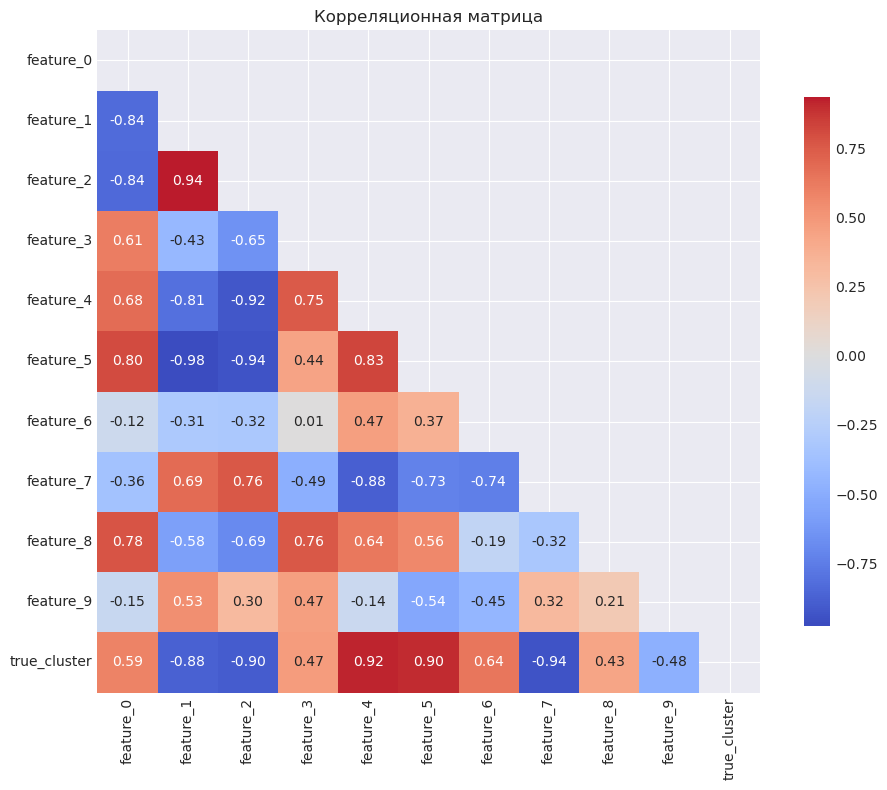

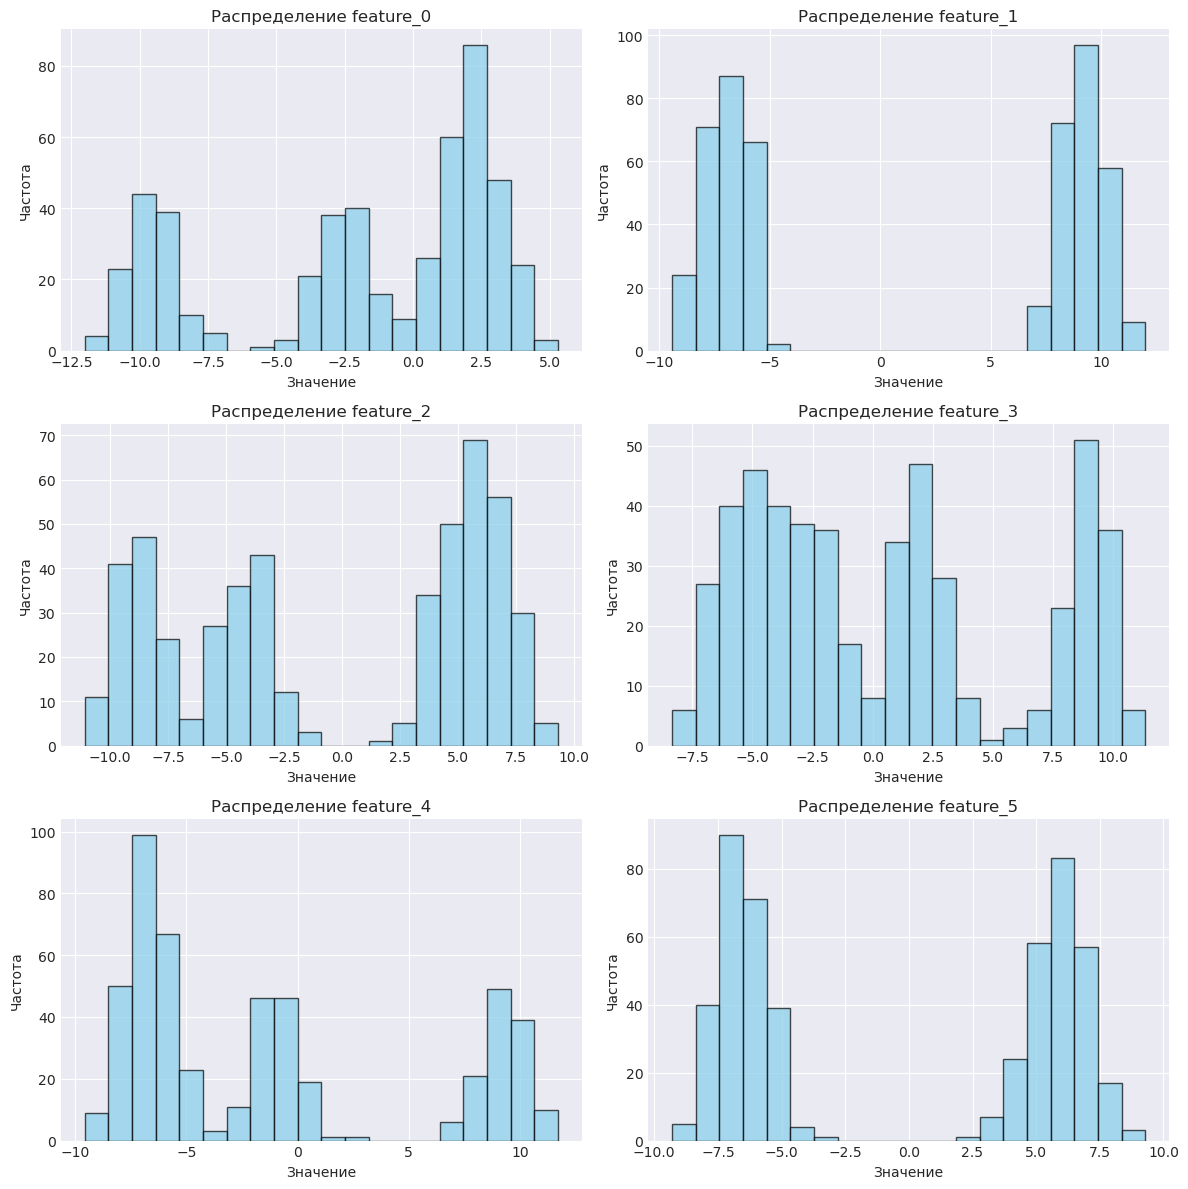

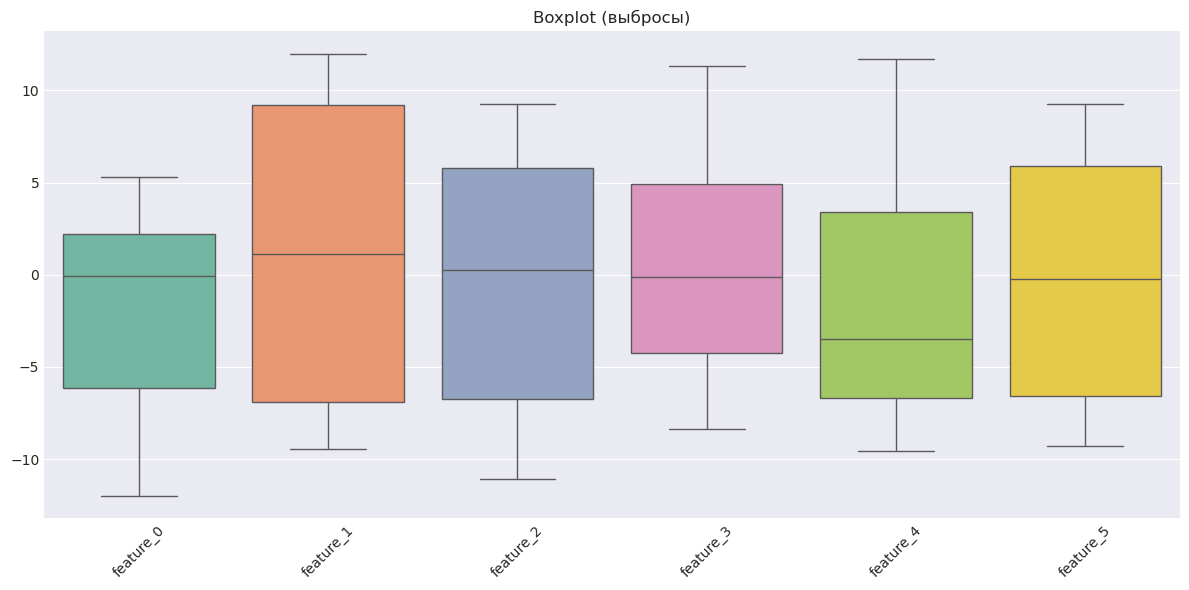


🔍 ЗАПУСК КЛАСТЕРИЗАЦИИ
📊 Использовано 11 числовых признаков

🔍 АНАЛИЗ КЛАСТЕРИЗАЦИИ

📐 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ
----------------------------------------
Кластеров:  2 | WCSS:    2272.55 | Silhouette: 0.5516
Кластеров:  3 | WCSS:    1232.23 | Silhouette: 0.6433
Кластеров:  4 | WCSS:     323.65 | Silhouette: 0.7322
Кластеров:  5 | WCSS:     301.16 | Silhouette: 0.6053
Кластеров:  6 | WCSS:     279.81 | Silhouette: 0.4803
Кластеров:  7 | WCSS:     264.07 | Silhouette: 0.3374
Кластеров:  8 | WCSS:     246.44 | Silhouette: 0.1997
Кластеров:  9 | WCSS:     234.08 | Silhouette: 0.1962

✅ Оптимальное количество кластеров: 4 (Silhouette: 0.7322)


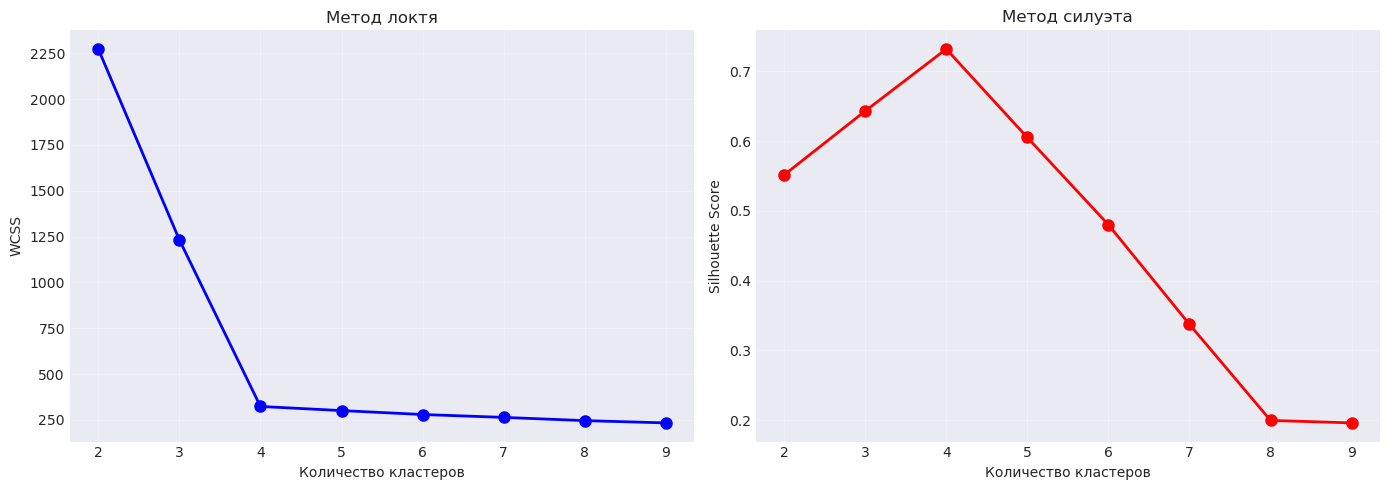


🤖 ПРИМЕНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ (n_clusters=4)
----------------------------------------

📊 Алгоритм: K-Means
   Количество кластеров: 4
   Silhouette Score: 0.7322
   Davies-Bouldin Index: 0.3898
   Calinski-Harabasz Index: 2644.2640

📊 Алгоритм: Agglomerative
   Количество кластеров: 4
   Silhouette Score: 0.7322
   Davies-Bouldin Index: 0.3898
   Calinski-Harabasz Index: 2644.2640

📊 Алгоритм: Gaussian Mixture
   Количество кластеров: 4
   Silhouette Score: 0.7322
   Davies-Bouldin Index: 0.3898
   Calinski-Harabasz Index: 2644.2640

📊 Алгоритм: DBSCAN
   Количество кластеров: 9
   Silhouette Score: -0.3658
   Davies-Bouldin Index: 1.5228
   Calinski-Harabasz Index: 30.3324

🎨 ВИЗУАЛИЗАЦИЯ КЛАСТЕРИЗАЦИИ
🏆 Лучший алгоритм: K-Means
📊 Silhouette Score: 0.7322
🔢 Количество кластеров: 4


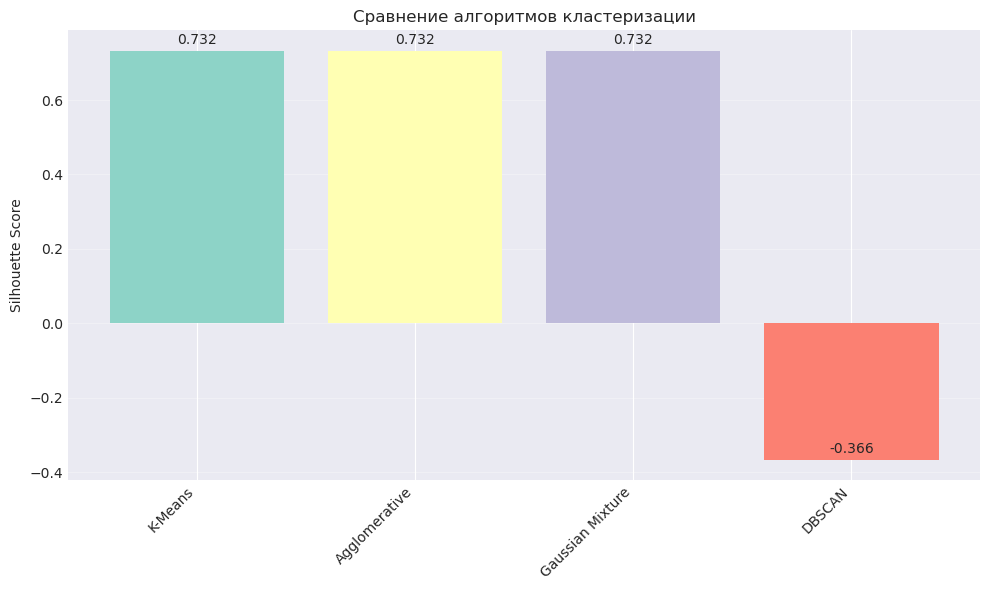

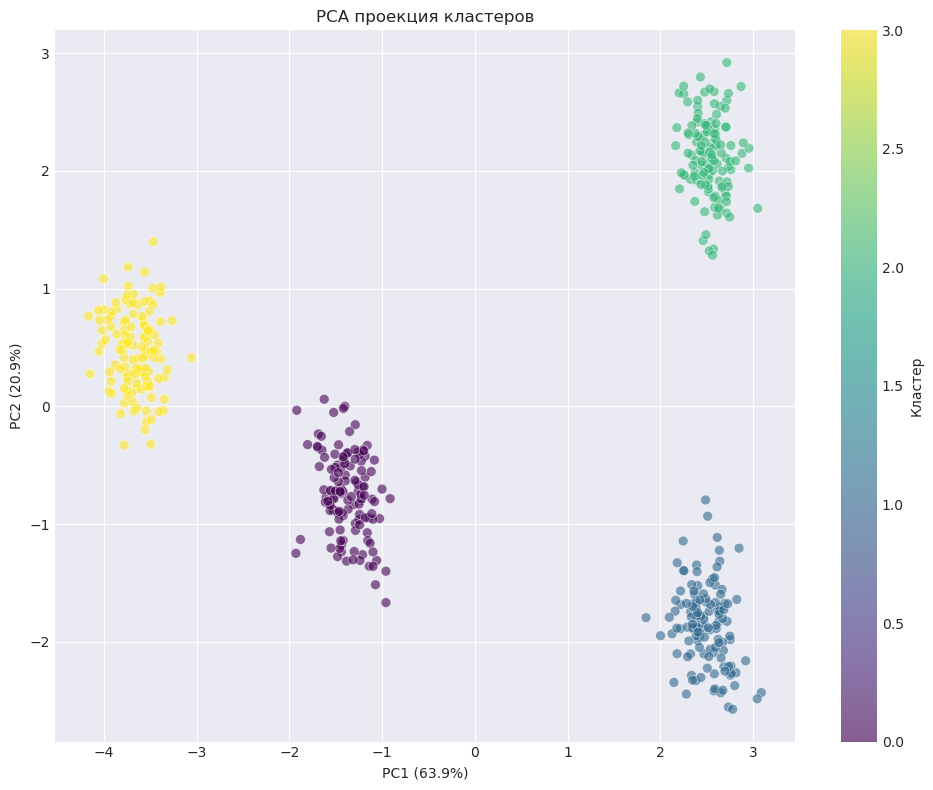

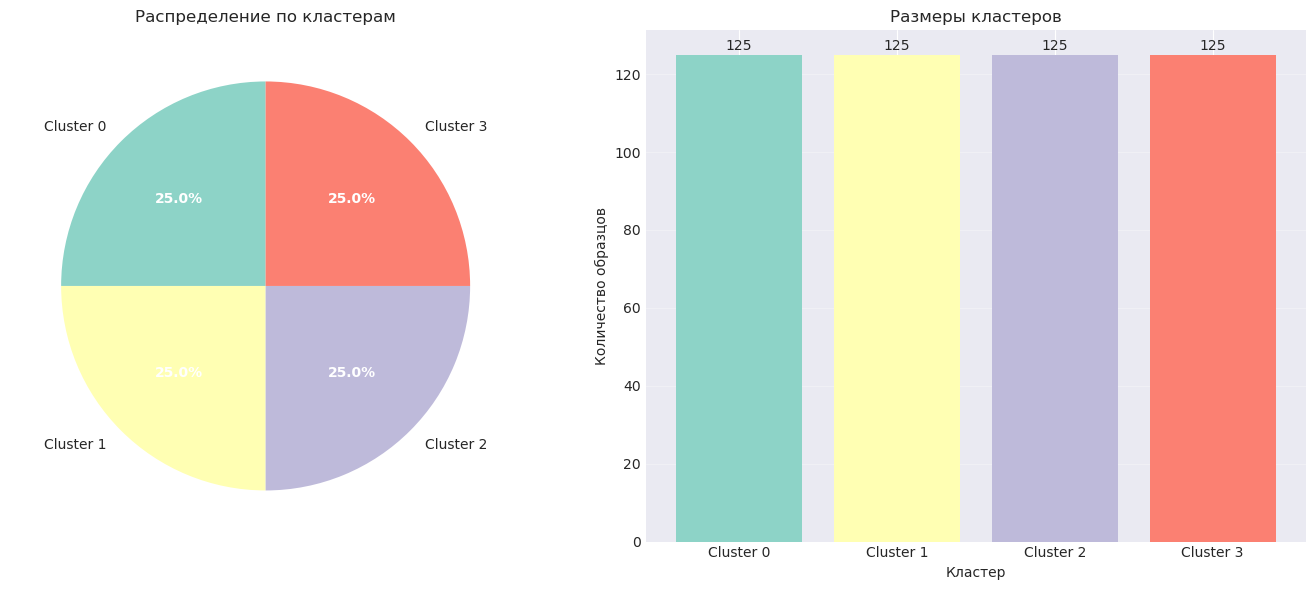

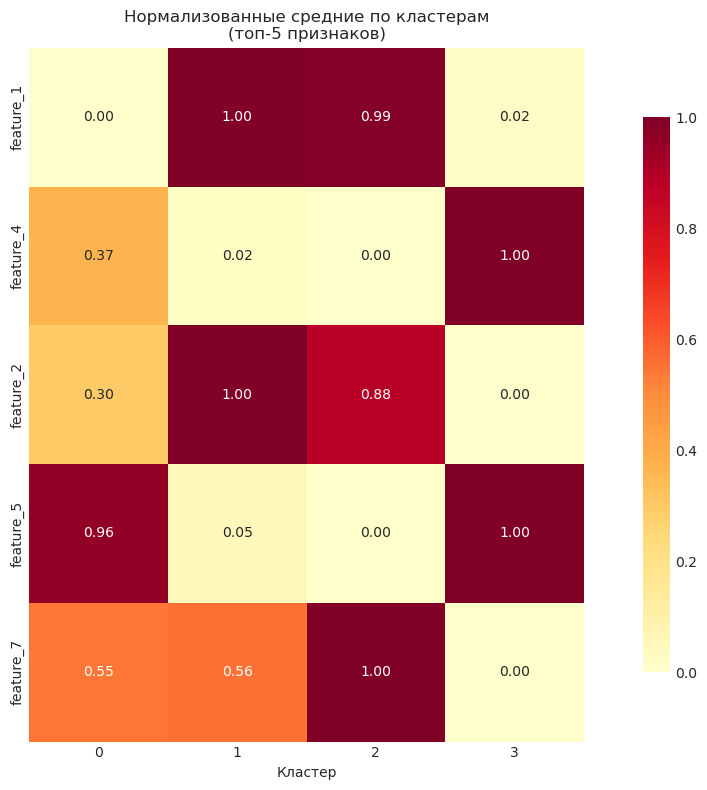


📊 ДЕТАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:
----------------------------------------

🔹 Cluster 0: 125 образцов (25.0%)
   Топ-3 признака (наибольшие значения):
     feature_5: 5.632
     feature_0: 2.211
     true_cluster: 2.000

🔹 Cluster 1: 125 образцов (25.0%)
   Топ-3 признака (наибольшие значения):
     feature_1: 9.299
     feature_2: 6.635
     true_cluster: 1.000

🔹 Cluster 2: 125 образцов (25.0%)
   Топ-3 признака (наибольшие значения):
     feature_1: 9.107
     feature_7: 7.478
     feature_2: 4.781

🔹 Cluster 3: 125 образцов (25.0%)
   Топ-3 признака (наибольшие значения):
     feature_4: 9.253
     feature_3: 8.891
     feature_5: 6.176

✅ АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!


In [38]:
# ==================== ГЛАВНЫЙ БЛОК ====================

if __name__ == "__main__":
    # Запуск примера анализа
    analyzer = run_example_analysis()